# Randomized Image Sampling for Explanations (RISE)

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize as resize1
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras as keras
import gym
import tensorforce
from tensorforce import Agent, Environment

from PIL import Image
import torchvision.transforms as T
import torch

import math
import random
import numpy as np

## Cargar agente y definición de entorno

In [2]:
agent = Agent.load(directory='DQNVisionCartPolemodel3')

In [3]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

class CartPoleVisionEnvironment(Environment):

    def __init__(self):
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.init_screen = self.get_screen()
        self.init_state = (self.get_screen() - self.init_screen).cpu().squeeze(0).permute(1, 2, 0).numpy()
        self.last_screen = self.init_screen
        self.current_screen = self.init_screen
        super().__init__()
        
    def get_cart_location(self, screen_width):
        world_width = self.env.x_threshold * 2
        scale = screen_width / world_width
        return int(self.env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART
        
    def get_screen(self):
        # Returned screen requested by gym is 400x600x3, but is sometimes larger
        # such as 800x1200x3. Transpose it into torch order (CHW).
        screen = self.env.render(mode='rgb_array').transpose((2, 0, 1))
        # Cart is in the lower half, so strip off the top and bottom of the screen
        _, screen_height, screen_width = screen.shape
        screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
        view_width = int(screen_width * 0.6)
        cart_location = self.get_cart_location(screen_width)
        if cart_location < view_width // 2:
            slice_range = slice(view_width)
        elif cart_location > (screen_width - view_width // 2):
            slice_range = slice(-view_width, None)
        else:
            slice_range = slice(cart_location - view_width // 2,
                                cart_location + view_width // 2)
        # Strip off the edges, so that we have a square image centered on a cart
        screen = screen[:, :, slice_range]
        # Convert to float, rescale, convert to torch tensor
        # (this doesn't require a copy)
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        # Resize, and add a batch dimension (BCHW)
        return resize(screen).unsqueeze(0)
    
    def is_vectorizable(self):
        return True                          
    
    def actions(self):
        return dict(type='int', shape=(), num_values=2)

    def states(self):
        return dict(type='float', shape=self.init_state.shape)

    def execute(self, actions):
        _, reward, done, _ = self.env.step(actions)
        self.last_screen = self.current_screen
        self.current_screen = self.get_screen()
        if not done:
            next_state = (self.current_screen - self.last_screen).cpu().squeeze(0).permute(1, 2, 0).numpy()
        else: next_state = None
        return next_state, done, reward
    
    def reset(self):
        self.env.reset()
        self.last_screen = self.init_screen
        self.current_screen = self.init_screen
        return self.init_state

/opt/anaconda3/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


## Métodos específicos RISE

In [4]:
def generate_masks(N, s, p1, dimx = 40, dimy = 90):
    cell_size = np.ceil(np.array((dimx,dimy)) / s) # si dividimos en s "cachos" dim entera
    up_size = (s + 1) * cell_size # si cupiese uno mas dim
    
    grid = np.random.rand(N, s, s) < p1 #generar cuadrado s * s con 0 o 1
    grid = grid.astype('float32')
    masks = np.empty((N, dimx,dimy)) #lo rellenaremos

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0]) #cuando shift en x
        y = np.random.randint(0, cell_size[1]) #cuanto shift en y
        # Linear upsampling and cropping
        masks[i, :, :] = resize1(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + dimx, y:y + dimy]
        
    masks = masks.reshape(-1, dimx,dimy , 1)
    return masks

In [5]:
def explain(inp, masks , agent, dimx = 40, dimy = 90):
    preds = []
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    
    #print(masked.shape) # = (2000, 40, 90, 3) => N alteraciones de la imagen x 
    for i in tqdm(range (0,N), desc = 'Explaining'):
        decision = agent.act(states=masked[i], independent = True, deterministic=True)
        elem = agent.tracked_tensors()['agent/policy/action-values']
        softmax = tf.nn.softmax(elem).numpy()
        preds.append(softmax)
    
    preds = np.array(preds)
    

    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, dimx,dimy)
    sal = sal / N / p1
    return sal


In [6]:
def saliency(class_idx,img, sal):
    plt.title('Explanation for `{}`'.format(act_dict[class_idx]))
    plt.axis('off')
    plt.imshow(img)
    plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
    plt.show()

## Creación de la explicación

In [7]:
act_dict = {0:'LEFT',1:'RIGHT'}
environment =  Environment.create(environment = CartPoleVisionEnvironment, max_episode_timesteps=10000)
states = environment.reset()
terminal = False
#constantes generacion mascaras
N = 4000
s = 8
p1 = 0.5
masks = generate_masks(N, s, p1)

Generating masks: 100%|██████████| 4000/4000 [00:03<00:00, 1311.13it/s]


Explaining: 100%|██████████| 4000/4000 [00:37<00:00, 107.93it/s]


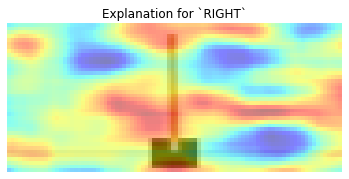

Explaining: 100%|██████████| 4000/4000 [00:38<00:00, 103.99it/s]


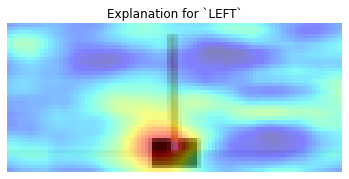

Explaining: 100%|██████████| 4000/4000 [00:41<00:00, 96.35it/s] 


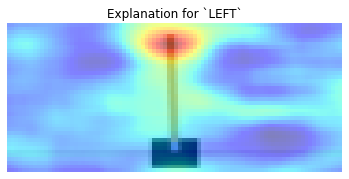

Explaining:  54%|█████▎    | 2141/4000 [00:21<00:18, 99.04it/s] 


KeyboardInterrupt: 

In [8]:
i=0
while(not terminal):
    screen = environment.get_screen()
    transform = T.ToPILImage()
    img = transform(screen[0])
    actions = agent.act(states=states, independent = True, deterministic=True)
    if i % 5 == 0:
        sal = explain(states, masks , agent)
        saliency(actions,img,sal)
    states, terminal, reward = environment.execute(actions=actions)
    i = i+1

In [ ]:
environment.close()